In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
import warnings
warnings.filterwarnings(action='ignore')

data = pd.read_csv('/content/drive/MyDrive/FYP Data/Main/Dera Ghazi Khan CSV.csv')
data = data.drop(['Year', 'Month'], axis=1)

def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Prediction':predictions, 'Actual Value':y})
  plt.plot(df['Prediction'][start:end])
  plt.plot(df['Actual Value'][start:end])
  return df, mse(y, predictions)

data

,M_Date,Maximum Temperature,Minimum Temperature,Precipitation,Soil Moisture,Wind Speed,Runoff,Flood
0,1/1/1958,22.95,7.13,5.8,1.8,0.81,0.3,False
1,2/1/1958,24.60,8.79,1.6,1.8,1.41,0.1,False
2,3/1/1958,31.00,14.77,1.4,1.7,1.81,0.1,False
3,4/1/1958,38.57,22.08,0.3,1.6,2.10,0.0,False
4,5/1/1958,40.25,23.32,1.4,1.6,2.65,0.1,False
...,...,...,...,...,...,...,...,...
773,6/1/2022,34.40,18.00,110.0,0.1,2.00,0.9,True
774,7/1/2022,32.70,14.80,184.0,0.2,1.20,4.7,True
775,8/1/2022,30.60,13.10,155.0,0.2,0.90,2.9,True
776,9/1/2022,31.20,16.20,2.0,0.1,0.60,2.1,False


In [ ]:
data.index = pd.to_datetime(data['M_Date'], format='%m/%d/%Y')

temp_df = pd.DataFrame({'Max_Temperature':data['Maximum Temperature'], 'Min_Temperature':data['Minimum Temperature'], 'Precipitation':data['Precipitation'], 'Soil Moisture':data['Soil Moisture'],
                        'Wind Speed':data['Wind Speed'], 'Runoff':data['Runoff'], 'Flood':data['Flood']})

le = LabelEncoder()
temp_df['Flood'] = le.fit_transform(temp_df.Flood.values)
scaler = MinMaxScaler()
temp_df[['Max_Temperature', 'Min_Temperature', 'Precipitation', 'Soil Moisture', 'Wind Speed', 'Runoff', 'Flood']] = scaler.fit_transform(temp_df[['Max_Temperature', 'Min_Temperature', 'Precipitation', 'Soil Moisture',
        'Wind Speed', 'Runoff', 'Flood']])

temp_df

,Max_Temperature,Min_Temperature,Precipitation,Soil Moisture,Wind Speed,Runoff,Flood
M_Date,,,,,,,
1958-01-01,0.332892,0.195527,0.029087,0.122302,0.218919,0.03,0.0
1958-02-01,0.387546,0.255411,0.008024,0.122302,0.381081,0.01,0.0
1958-03-01,0.599536,0.471140,0.007021,0.115108,0.489189,0.01,0.0
1958-04-01,0.850282,0.734848,0.001505,0.107914,0.567568,0.00,0.0
1958-05-01,0.905929,0.779582,0.007021,0.107914,0.716216,0.01,0.0
...,...,...,...,...,...,...,...
2022-06-01,0.712156,0.587662,0.551655,0.000000,0.540541,0.09,1.0
2022-07-01,0.655846,0.472222,0.922768,0.007194,0.324324,0.47,1.0
2022-08-01,0.586287,0.410895,0.777332,0.007194,0.243243,0.29,1.0


In [ ]:
def df_to_X_y(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][6]
    y.append(label)

  return np.array(X), np.array(y)

X, y = df_to_X_y(temp_df)

X_train, y_train = X[:500], y[:500]
X_val, y_val = X[500:600], y[500:600]
X_test, y_test = X[600:], y[600:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((500, 6, 7), (500,), (100, 6, 7), (100,), (172, 6, 7), (172,))

In [ ]:
model = Sequential()
model.add(InputLayer((6, 7)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

m_checkpoint = ModelCheckpoint('model_DG/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.000001), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[m_checkpoint])

Epoch 1/5
16/16 [==============================] - 8s 368ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 5.5113e-04 - val_root_mean_squared_error: 0.0235
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 5.5593e-04 - val_root_mean_squared_error: 0.0236
Epoch 3/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 5.6630e-04 - val_root_mean_squared_error: 0.0238
Epoch 4/5
16/16 [==============================] - 0s 10ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - val_loss: 5.7167e-04 - val_root_mean_squared_error: 0.0239
Epoch 5/5
16/16 [==============================] - 0s 10ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486 - val_loss: 5.7873e-04 - val_root_mean_squared_error: 0.0241


6/6 [==============================] - 0s 3ms/step


(     Prediction  Actual Value
 0      0.015740           0.0
 1      0.024135           0.0
 2      0.034257           0.0
 3      0.047065           0.0
 4      0.043923           0.0
 ..          ...           ...
 167    0.002665           1.0
 168   -0.006679           1.0
 169   -0.000845           1.0
 170    0.008438           0.0
 171    0.035056           0.0
 
 [172 rows x 2 columns], 0.03649245027281172)

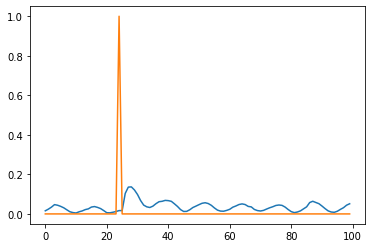

In [ ]:
model = load_model('model_DG/')

plot_predictions(model, X_test, y_test)